In [60]:

def get_df_from_url(url):
    import pandas as pd
    try:
        df = pd.read_csv(url, index_col=0)
    except pd.errors.ParserError:
        csv = read_from_url(url)
        df = pd.DataFrame(csv)
    try:
        resp = df
    except Exception as ex:
        resp = df
    return resp
def read_from_url(url):
    import requests
    import re
    def make_entry(x):
        return {
            'server_ip':x.group('ip'),
            'uri':x.group('uri'),
            'time':x.group('time'),
            'method':x.group(3),
            'status_code':x.group('status_code'),
            'referral':x.group('referral'),
            'agent':x.group('agent'),
            }
    try:
        data = requests.get(url).text.split('\n')
    except:
        pass
    log_re = '(?P<ip>[.:0-9a-fA-F]+) - - \[(?P<time>.*?)\] "\\b(GET|POST|HEAD|PUT|OPTIONS|DELETE|CONNECT|TRACE)\\b (?P<uri>.*?) HTTP/1.\d" (?P<status_code>\d+) (?P<bytes_tranfered>\d+) "(?P<referral>.*?)" "(?P<agent>.*?)"'
    search = re.compile(log_re).search
    matches = (search(line) for line in data)
    return [make_entry(x) for x in matches if x]

In [66]:
url = "https://raw.githubusercontent.com/ayedaemon/RuckSack-Python/master/log_analysis/access_log"
df = get_df_from_url(url)

In [68]:
df = get_df_from_url(url)


In [69]:
df['server_ip'].value_counts().head(5)

172.17.0.1    763
127.0.0.1       4
Name: server_ip, dtype: int64

In [70]:
def mostvisitedandleastvisiteduser(df,n=1,m=1):
    ans = {}
    ans['Top visited User'] = list(df['server_ip'].value_counts().head(n).index)
    ans['Least visited User'] = list(df['server_ip'].value_counts().tail(m).index)
    return ans

In [71]:
mostvisitedandleastvisiteduser(df,n=1,m=1)

{'Top visited User': ['172.17.0.1'], 'Least visited User': ['127.0.0.1']}

In [72]:
def mostvisited_and_leastvisitedpage(df,n=1,m=1):
    result = {}
    pages = df.uri.apply(lambda x: x.split('?')[0])
    result['Top visited Page'] = list(pages.value_counts().head(n).index)
    result['Least Visited Page'] = list(pages.value_counts().tail(m).index)
    return result

In [73]:
mostvisited_and_leastvisitedpage(df)

{'Top visited Page': ['/cgi-bin/weak_form.py'],
 'Least Visited Page': ['/noindex/common/images/pb-centos.png']}

In [74]:
def XSS(str_):
    flag = 0
    l1 = ['<','>','\\','`']
    l2 = ['/',')','(']
    for char in l1:
        aasci_encoding = '%'+hex(ord(char)).replace('0x','')
        if (char in str_) or (aasci_encoding in str_):
            flag = 1
            break
    if flag != 1:
        try:
            req_str = ''.join(str_.split('?')[1:])
            for char in l2:
                aasci_encoding = '%'+hex(ord(char)).replace('0x','')
                if (char in req_str) or (aasci_encoding in req_str):
                    flag = 1
                    break
        except:
            pass
    return bool(flag)

In [75]:
df['XSS_attack'] = df['uri'].apply(XSS)

In [76]:
df[df.XSS_attack == True].head(10)

,server_ip,uri,time,method,status_code,referral,agent,XSS_attack
749,172.17.0.1,/cgi-bin/weak_form.py?fname=asdasd%3C%2Fp%3E%3...,15/Jan/2021:10:05:35 +0000,GET,200,http://172.17.0.2/cgi-bin/weak_form.py?fname=s...,Mozilla/5.0 (X11; Linux x86_64; rv:84.0) Gecko...,True
752,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:29:02 +0000,GET,200,-,curl/7.74.0,True
753,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:30:04 +0000,GET,200,-,curl/7.74.0,True
754,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:30:42 +0000,GET,200,-,curl/7.74.0,True
755,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:30:57 +0000,GET,200,-,curl/7.74.0,True
756,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:31:04 +0000,GET,200,-,curl/7.74.0,True
757,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:31:24 +0000,GET,200,-,curl/7.74.0,True
758,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:31:28 +0000,GET,200,-,curl/7.74.0,True
759,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:31:34 +0000,GET,200,-,curl/7.74.0,True
760,172.17.0.1,/cgi-bin/weak_form.py?fname=abcd&lname=111</p>...,16/Jan/2021:05:32:02 +0000,GET,200,-,curl/7.74.0,True


In [77]:
import re
from collections import Counter
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import pandas as pd
import requests
from urllib.request import urlopen
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
import time
!pip install geopy
from geopy.geocoders import Nominatim
from random import randint


In [53]:
!pip install folium
!pip install geonamescache
from geonamescache import GeonamesCache
#import helpers
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
#from mpl_toolkits.basemap import Basemap
import folium
from folium.plugins import MarkerCluster

In [78]:
def OS_dict(browser_series):
    os = ['Windows','Linux','Opera','Other']
    res_dict = {o:0 for o in os}
    for browser in browser_series:
        flag = 0
        for i in os[:-1]:
            if i in browser:
                res_dict[i]+=1
                flag = 1
                break
        if flag==0:
            res_dict['Other']+=1
    return res_dict

In [79]:
OS = OS_dict(df['agent'])

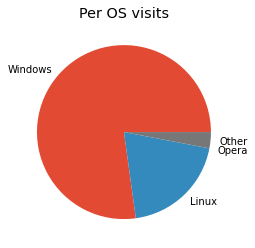

In [80]:
plt.pie( list(OS.values()), labels=list(OS.keys()))
plt.title("Per OS visits")
plt.show()